In [1]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_anomaly_detection

In [2]:
%presentation_style

In [3]:
%%capture

%set_random_seed 12

In [4]:
%load_latex_macros


$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\newcommand{\amax}{{\text{argmax}}}$
$\newcommand{\P}{{\mathbb{P}}}$
$\newcommand{\E}{{\mathbb{E}}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\Z}{{\mathbb{Z}}}$
$\newcommand{\N}{{\mathbb{N}}}$
$\newcommand{\C}{{\mathbb{C}}}$
$\newcommand{\abs}[1]{{ \left| #1 \right| }}$
$\newcommand{\simpl}[1]{{\Delta^{#1} }}$


# Anomaly Detection via Density Estimation
<img src="_static/images/aai-institute-cover.png" alt="Snow" style="width:100%;">

In [ ]:
import ipywidgets as widgets
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px


from ipywidgets import interact
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import IsolationForest
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from tensorflow import keras
from tqdm import tqdm

from tfl_training_anomaly_detection.exercise_tools import (
    evaluate, 
    get_kdd_data, 
    get_house_prices_data, 
    create_distributions, 
    contamination, 
    perform_rkde_experiment, 
    get_mnist_data
)
from tfl_training_anomaly_detection.vae import VAE, build_decoder_mnist, build_encoder_minst, build_contaminated_minst

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 5)


# Anomaly Detection via Density Estimation
**Idea:** Estimate the density of $F_0$. Areas of low density are anomalous.
- Often $p$ is too small to estimate complete mixture model
- Takes into account that $F_1$ might not be well-defined
- Estimation procedure needs to be robust against contamination if no clean training data is available

## Kernel Density Estimation
- Non-parametric method
- Can represent almost arbitrarily shaped densities
- Each training point "spreads" a fraction of the probability mass as specified by the kernel function

**Definition**

---
<img src="_static/images/kernels.png" style="margin:0px 100px" width="600" align="right">

**Definition:**
- $K: \mathbb{R} \to \mathbb{R}$ kernel function
    - $K(r) \geq 0$ for all $r\in \mathbb{R}$
	- $\int_{-\infty}^{\infty} K(r) dr = 1$
- $h > 0$ bandwidth
- Bandwidth is the most crucial parameter
---





**Definition:**

---
Let $D = \{x_1,\ldots,x_N\}\subset \mathbb{R}^p$. The KDE with symmetric kernel $K$ and bandwidth $h$ is
$KDE_h(x, D) = \frac{1}{N}\sum_{i=1}^N \frac{1}{h^p}K\left(\frac{x-x_i}{h}\right)$

---

<table style="width:60%">
    <tr>
        <td width="20%" style="background-color:#FFFFFF;"><img src="_static/images/bandwidth.png" width="100"></td>
        <td style="background-color:#FFFFFF;"><img src="_static/images/1dkde.png"></td>
    </tr>
    <tr>
        <td style="background-color:#FFFFFF;" colspan="2"><center>Effect of bandwidth and kernel</center></td>
    </tr>
</table>

### Exercise
Play with the parameters!

In [ ]:
dists = create_distributions(dim=2, dim_irrelevant=0)

sample_train = dists['Double Blob'].sample(500)
X_train = sample_train[-1]
y_train = [0]*len(X_train)

plt.scatter(X_train[:,0], X_train[:,1], c = 'blue', s=10)
plt.show()

In [ ]:
# Helper function
def fit_kde(kernel: str, bandwidth: float, X_train: np.array) -> KernelDensity:
    """ Fit KDE
    
    @param kernel: kernel
    @param bandwidth: bandwidth
    @param x_train: data
    """
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde.fit(X_train)
    return kde

def visualize_kde(kde: KernelDensity, bandwidth: float, X_test: np.array, y_test: np.array) -> None:
    """Plot KDE
    
    @param kde: KDE
    @param bandwidth: bandwidth
    @param X_test: test data
    @param y_test: test label
    """
    fig, axis = plt.subplots(figsize=(5, 5))

    lin = np.linspace(-10, 10, 50)
    grid_points = list(it.product(lin, lin))
    ys, xs = np.meshgrid(lin, lin)
    # The score function of sklearn returns log-densities
    scores = np.exp(kde.score_samples(grid_points)).reshape(50, 50)
    colormesh = axis.contourf(xs, ys, scores)
    fig.colorbar(colormesh)
    axis.set_title('Density Conturs (Bandwidth={})'.format(bandwidth))
    axis.set_aspect('equal')
    color = ['blue' if i ==0 else 'red' for i in y_test]
    plt.scatter(X_test[:, 0], X_test[:, 1], c=color)
    plt.show()

# Choose KDE Parameters

In [ ]:
ker = None
bdw = None
@interact(
    kernel=['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'],
    bandwidth=(.1, 10.)
)
def set_kde_params(kernel: str, bandwidth: float) -> None:
    """Helper funtion to set widget parameters
    
    @param kernel: kernel
    @param bandwidth: bandwidth
    """
    global ker, bdw

    ker = kernel
    bdw = bandwidth

In [ ]:
kde = fit_kde(ker, bdw, X_train)
visualize_kde(kde, bdw, X_train, y_train)

## Bandwidth Selection
The bandwidth is the most important parameter of a KDE model. A wrongly adjusted value will lead to over- or
under-smoothing of the density curve.

A common method to select a bandwidth is maximum log-likelihood cross validation.
$$h_{\textrm{llcv}} = \arg\max_{h}\frac{1}{k}\sum_{i=1}^k\sum_{y\in D_i}\log\left(\frac{k}{N(k-1)}\sum_{x\in D_{-i}}K_h(x, y)\right)$$
where $D_{-i}$ is the data without the $i$th cross validation fold $D_i$.

# Exercises

ex no.1: Noisy sinusoidal

In [ ]:
# Generate example
dists = create_distributions(dim=2)

distribution_with_anomalies = contamination(
    nominal=dists['Sinusoidal'],
    anomaly=dists['Blob'],
    p=0.05
)

# Train data
sample_train = dists['Sinusoidal'].sample(500)
X_train = sample_train[-1].numpy()

# Test data
sample_test = distribution_with_anomalies.sample(500)
X_test = sample_test[-1].numpy()
y_test = sample_test[0].numpy()

scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
handels, _ = scatter.legend_elements()
plt.legend(handels, ['Nominal', 'Anomaly'])
plt.gca().set_aspect('equal')
plt.show()

### Exercise: Define the search space for the kernel and the bandwidth

In [ ]:
param_space = {
    'kernel': ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'], # Add available kernels
    'bandwidth': np.linspace(0.1, 10, 100), # Define Search space for bandwidth parameter
}

In [ ]:
def hyperopt_by_score(X_train: np.array, param_space: dict, cv: int=5):
    """Performs hyperoptimization by score
    
    @param X_train: data
    @param param_space: parameter space
    @param cv: number of cv folds
    """
    kde = KernelDensity()

    search = RandomizedSearchCV(
        estimator=kde,
        param_distributions=param_space,
        n_iter=100,
        cv=cv,
        scoring=None # use estimators internal scoring function, i.e. the log-probability of the validation set for KDE
    )

    search.fit(X_train)
    return search.best_params_, search.best_estimator_

Run the code below to perform hyperparameter optimization.

In [ ]:
params, kde = hyperopt_by_score(X_train, param_space)

print('Best parameters:')
for key in params:
    print('{}: {}'.format(key, params[key]))

test_scores = -kde.score_samples(X_test)
test_scores = np.where(test_scores == np.inf, np.max(test_scores[np.isfinite(test_scores)])+1, test_scores)

curves = evaluate(y_test, test_scores)

In [ ]:
visualize_kde(kde, params['bandwidth'], X_test, y_test)

### Exercise: Isolate anomalies in house prices

You are a company resposible to estimate house prices around Ames, Iowa, specifically around college area. But there is a problem: houses from a nearby area, 'Veenker', are often included in your dataset. You want to build an anomaly detection algorithm that filters one by one every point that comes from the wrong neighborhood. You have been able to isolate an X_train dataset which, you are sure, contains only houses from College area. Following the previous example, test your ability to isolate anomalies in new incoming data (X_test) with KDE.

Advanced exercise:
What happens if the contamination comes from other areas? You can choose among the following names:

OldTown, Veenker, Edwards, MeadowV, Somerst, NPkVill, BrDale, Gilbert, NridgHt, Sawyer, Blmngtn, Blueste

In [ ]:
X_train, X_test, y_test = get_house_prices_data(neighborhood = 'CollgCr', anomaly_neighborhood='Veenker')
X_train

In [ ]:
# Total data
train_test_data = X_train._append(X_test, ignore_index=True)
y_total = [0] * len(X_train) + y_test

fig = px.scatter_3d(train_test_data, x='LotArea', y='OverallCond', z='SalePrice', color=y_total)

fig.show()

### Solution

In [ ]:
# When data are highly in-homogeneous, like in this case, it is often beneficial 
# to rescale them before applying any anomaly detection or clustering technique.
scaler = MinMaxScaler()
X_train_rescaled = scaler.fit_transform(X_train)

In [ ]:
param_space = {
    'kernel': ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'], # Add available kernels
    'bandwidth': np.linspace(0.1, 10, 100), # Define Search space for bandwidth parameter
}
params, kde = hyperopt_by_score(X_train_rescaled, param_space)

In [ ]:
print('Best parameters:')
for key in params:
    print('{}: {}'.format(key, params[key]))

X_test_rescaled = scaler.transform(X_test)
test_scores = -kde.score_samples(X_test_rescaled)
test_scores = np.where(test_scores == np.inf, np.max(test_scores[np.isfinite(test_scores)])+1, test_scores)
curves = evaluate(y_test, test_scores)

## The Curse of Dimensionality
The flexibility of KDE comes at a price. The dependency on the dimensionality of the data is quite unfavorable.


*Theorem* [Stone, 1982]
Any estimator that is consistent$^*$ with the class of all $k$-fold differentiable pdfs over $\mathbb{R}^d$ has a
convergence rate of at most

$$
\frac{1}{n^{\frac{k}{2k+d}}}
$$




$^*$Consistency = for all pdfs $p$ in the class: $\lim_{n\to\infty}|KDE_h(x, D) - p(x)|_\infty = 0$ with probability $1$.

# Exercise
- The very slow convergence in high dimensions does not necessary mean that we will see bad results in high dimensional anomaly detection with KDE.
- Especially if the anomalies are very outlying.
- However, in cases where contours of the nominal distribution are non-convex we can run into problems.

We take a look at a higher dimensional version of out previous data set.

In [ ]:
dists = create_distributions(dim=3)

distribution_with_anomalies = contamination(
    nominal=dists['Sinusoidal'],
    anomaly=dists['Blob'],
    p=0.01
)

sample = distribution_with_anomalies.sample(500)

y = sample[0]
X = sample[-1]

In [ ]:
fig = px.scatter_3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], color=y)
fig.show()

In [ ]:
# Fit KDE on high dimensional examples 
rocs = []
auprs = []
bandwidths = []

param_space = {
        'kernel': ['gaussian'],
        'bandwidth': np.linspace(0.1, 100, 1000), # Define Search space for bandwidth parameter
    }

kdes = {}
dims = np.arange(2,16)
for d in tqdm(dims):
    # Generate d dimensional distributions
    dists = create_distributions(dim=d)

    distribution_with_anomalies = contamination(
        nominal=dists['Sinusoidal'],
        anomaly=dists['Blob'],
        p=0
    )

    # Train on clean data
    sample_train = dists['Sinusoidal'].sample(500)
    X_train = sample_train[-1].numpy()
    # Test data
    sample_test = distribution_with_anomalies.sample(500)
    X_test = sample_test[-1].numpy()
    y_test = sample_test[0].numpy()

    # Optimize bandwidth
    params, kde = hyperopt_by_score(X_train, param_space)
    kdes[d] = (params, kde)
    
    bandwidths.append(params['bandwidth'])

    test_scores = -kde.score_samples(X_test)
    test_scores = np.where(test_scores == np.inf, np.max(test_scores[np.isfinite(test_scores)])+1, test_scores)

    

In [ ]:
# Plot cross section of pdf 
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(15, 5))
for d, axis in tqdm(list(zip(kdes, axes.flatten()))):
    
    params, kde = kdes[d]

    lin = np.linspace(-10, 10, 50)
    grid_points = list(it.product(*([[0]]*(d-2)), lin, lin))
    ys, xs = np.meshgrid(lin, lin)
    # The score function of sklearn returns log-densities
    scores = np.exp(kde.score_samples(grid_points)).reshape(50, 50)
    colormesh = axis.contourf(xs, ys, scores)
    axis.set_title("Dim = {}".format(d))
    axis.set_aspect('equal')
    

# Plot evaluation
print('Crossection of the KDE at (0,...,0, x, y)')
plt.show()

## Robustness
Another drawback of KDE in the context of anomaly detection is that it is not robust against contamination of the data


**Definition**
The *breakdown point* of an estimator is the smallest fraction of observations that need to be changed so that we can
move the estimate arbitrarily far away from the true value.



**Example**: The sample mean has a breakdown point of $0$. Indeed, for a sample of $x_1,\ldots, x_n$ we only need to
change a single value in order to move the sample mean in any way we want. That means that the breakdown point is
smaller than $\frac{1}{n}$ for every $n\in\mathbb{N}$.

## Robust Statistics
There are robust replacements for the sample mean:
- Median of means: Split the dataset into $S$ equally sized subsets $X_1,\ldots, X_S$ and compute
$\mathrm{median}(\overline{X_1},\ldots, \overline{X_S})$
- M-estimation: The mean in a normed vector space is the value that minimizes the squared distances
<center>
$\overline{X} = \min_{y}\sum_{x\in X}|x-y|^2$
</center>
M-estimation replaces the quadratic loss with a more robust loss function.

### Huber loss
Switch from quadratic to linear loss at prescribed threshold

In [ ]:
import numpy as np


def huber(error: float, threshold: float):
    """Huber loss
    
    @param error: base error
    @param threshold: threshold for linear transition
    """
    test = (np.abs(error) <= threshold)
    return (test * (error**2)/2) + ((1-test)*threshold*(np.abs(error) - threshold/2))

x = np.linspace(-5, 5)
y = huber(x, 1)

plt.plot(x, y)
plt.gca().set_title("Huber Loss")
plt.show()

### Hampel loss
More complex loss function. Depends on 3 parameters 0 < a < b< r

In [ ]:
import numpy as np

def single_point_hampel(error: float, a: float, b: float, r: float):
    """Hampel loss
    
    @param error: base error
    @param a: 1st threshold parameter
    @param b: 2nd threshold parameter
    @param r: 3rd threshold parameter
    """
    if abs(error) <= a:
        return error**2/2
    elif a < abs(error) <= b:
        return (1/2 *a**2 + a* (abs(error)-a))
    elif  b < abs(error) <= r:
        return a * (2*b-a+(abs(error)-b) * (1+ (r-abs(error))/(r-b)))/2
    else:
        return a*(b-a+r)/2

hampel = np.vectorize(single_point_hampel)

x = np.linspace(-10.1, 10.1)
y = hampel(x, a=1.5, b=3.5, r=8)

plt.plot(x, y)
plt.gca().set_title("Hampel Loss")
plt.show()

## KDE is a Mean

<img src="_static/images/kernels.png" align="right" width="400" style="margin: 150px 75px">



**Kernel as scalar product:**

- Let $K$ be a radial monotonic$^\ast$ kernel over $\mathbb{R}^n$.
- For $x\in\mathbb{R}^n$ let $\phi_x = K(\cdot, x)$.
- Vector space over the linear span of $\{\phi_x \mid x\in\mathbb{R}^n\}$:
    - Pointwise addition and scalar multiplication.
- Define the scalar product $\langle \phi_x, \phi_y\rangle = K(x,y)$.
- Advantage: Scalar product is computable
- Call this the reproducing kernel Hilbert space (RKHS) of $K$.
- $\mathrm{KDE}_h(\cdot, D) = \frac{1}{N}\sum_{i=1}^N K_h(\cdot, x_i) = \frac{1}{N}\sum_{i=1}^N\phi_{x_i}$
    - where $K_h(x,y) = \frac{1}{h}K\left(\frac{x-y}{h}\right)$



$^*$All kernels that we have seen are radial and monotonic

# Exercise
We compare the performance of different approaches to recover the nominal distribution under contamination.
Here, we use code by [Humbert et al.](https://github.com/lminvielle/mom-kde) to replicate
the results in the referenced paper on median-of-mean KDE. More details on rKDE can instead be found in this paper by [Kim and Scott.](https://arxiv.org/abs/1107.3133#:~:text=We%20propose%20a%20method%20for,ideas%20from%20classical%20M%2Destimation.)

In [ ]:
# =======================================================
#   Parameters
# =======================================================
algos = [
    'kde',
    'mom-kde', # Median-of-Means
    'rkde-huber', # robust KDE with huber loss
    'rkde-hampel', # robust KDE with hampel loss
]

dataset = 'house-prices'
dataset_options = {'neighborhood': 'CollgCr', 'anomaly_neighborhood': 'Edwards'}

outlierprop_range = [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5]
kernel = 'gaussian'

In [ ]:
auc_scores = perform_rkde_experiment(
    algos,
    dataset,
    dataset_options,
    outlierprop_range,
    kernel,
)

In [33]:
algo_data

,algo,bandwidth,outlier_prop,n_block,auc_anomaly
0,kde,0.031623,0.01,None,0.960000
8,kde,0.031623,0.02,None,0.608889
16,kde,0.031623,0.03,None,0.733333
24,kde,0.056645,0.05,None,0.683810
32,kde,0.035533,0.07,None,0.851515
40,kde,0.044864,0.10,None,0.909167
48,kde,0.060046,0.20,None,0.856036
56,kde,0.056645,0.30,None,0.828125
64,kde,0.056645,0.40,None,0.822133
72,kde,0.047557,0.50,None,0.801000


Text(0.5, 1.0, 'Comparison of rKDE against contamination')

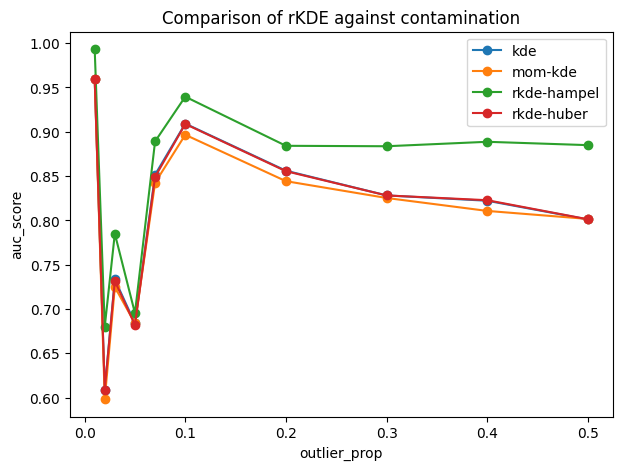

In [36]:
fig, ax = plt.subplots(figsize=(7, 5))
for algo, algo_data in auc_scores.groupby('algo'):
    algo_data = algo_data.drop("algo", axis=1)
    x = algo_data.groupby('outlier_prop').mean().index
    y = algo_data.groupby('outlier_prop').mean()['auc_anomaly']
    ax.plot(x, y, 'o-', label=algo)
plt.legend()
plt.xlabel('outlier_prop')
plt.ylabel('auc_score')
plt.title('Comparison of rKDE against contamination')

Try using different neighborhoods for contamination. Which robust KDE algorithm performs better overall? Choose among the following options:

OldTown, Veenker, Edwards, MeadowV, Somerst, NPkVill, BrDale, Gilbert, NridgHt, Sawyer, Blmngtn, Blueste

You can also change the kernel type: gaussian, tophat, epechenikov, exponential, linear or cosine, 

# Summary
- Kernel density estimation is a non-parametric method to estimate a pdf from a sample.
- Bandwidth is the most important parameter.
- Converges to the true pdf if $n\to\infty$.
    - Convergence exponentially depends on the dimension.
- KDE is sensitive to contamination:
    - In a contaminated setting one can employ methods from robust statistics to obtain robust estimates.
    
## Implementations
- Sklearn: [sklearn.neighbors.KernelDensity](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn.neighbors.KernelDensity)
- Statsmodels: [statsmodels.nonparametric.kernel_density.KDEMultivariate](https://www.statsmodels.org/dev/generated/statsmodels.nonparametric.kernel_density.KDEMultivariate.html)
- FastKDE: [link](https://pypi.org/project/fastkde/), offers automatic bandwidth and kernel selection.

<img src="_static/images/aai-institute-cover.png" alt="Snow" style="width:100%;">